In [1]:
from ete3 import Tree
import pandas as pd
import numpy as np
from typing import Optional
import os
import pickle
import sys

sys.path.append("/groups/itay_mayrose/halabikeren/tmp/plant_pollinator_inter/data_processing/name_resolution/")
from resolved_names_curator import ResolvedNamesCurator
from collections import defaultdict
import matplotlib.pyplot as plt

from Bio import Entrez

Entrez.email = "halabikeren@mail.tau.ac.il"

In [2]:
resolve_ccdb = False
resolve_tree = False
inlcude_missing_data = False
tree_name = "ALLMB"

resolved_tree_path = f"../trees/resolved_{tree_name}_name_resolution_on_{'none' if not resolve_tree and not resolve_ccdb else ('only_ccdb' if not resolve_tree else 'ccdb_and_tree')}.nwk"
if inlcude_missing_data:
    resolved_tree_path = f"../trees/{tree_name}.tre"
ppn_names_to_add_to_tree = "../trees/names_to_add_for_ppn_project.csv"
resolved_ccdb_path = f"../ccdb/resolved_data_name_resolved_on_{'ccdb_and_tree' if resolve_ccdb and resolve_tree else ('only_ccdb' if resolve_ccdb else 'none')}.csv"
full_ccdb_path = f"../ccdb/all_data_171122.csv"
resolved_tree_path_with_additions = f"../trees/new_resolved_{tree_name}_name_resolution_on_{'ccdb_and_tree' if resolve_ccdb and resolve_tree else ('only_ccdb' if resolve_ccdb else 'none')}_with_added_ccdb_{'and_wo_counts_' if inlcude_missing_data else ''}names.nwk"
reference_classification_data_path = "../trees/wfo_classification_data.csv"
tree_classification_data_path = (
    f"../trees/{os.path.basename(resolved_tree_path_with_additions).split('.')[0]}_classification_data.csv"
)

In [3]:
tree = Tree(resolved_tree_path, format=1)
for leaf in tree.get_leaves():
    leaf.name = leaf.name.lower().replace("_", " ")

resolved_ccdb = pd.read_csv(resolved_ccdb_path)
ccdb = pd.read_csv(full_ccdb_path)
resolved_ccdb = pd.read_csv(resolved_ccdb_path)

In [4]:
resolved_ccdb.original_names = resolved_ccdb.original_names.apply(lambda names: names.split(";"))
resolved_ccdb = resolved_ccdb.explode("original_names")
ccdb_orig_name_to_mapped_name = resolved_ccdb.set_index("original_names")["mapped_name"].to_dict()

In [5]:

def get_mapped_name(record: pd.Series) -> Optional[str]:
    if pd.notna(record.resolved_name):
        return ResolvedNamesCurator.fix_name(record.resolved_name)
    elif pd.notna(record.matched_name):
        return ResolvedNamesCurator.fix_name(record.matched_name)
    return np.nan


ccdb["mapped_name"] = ccdb[["original_name", "matched_name", "resolved_name"]].apply(
    lambda record: ccdb_orig_name_to_mapped_name.get(record.original_name.lower(), get_mapped_name(record)), axis=1
)
ccdb_names = set(ccdb.mapped_name.dropna().unique())
ccdb.to_csv(full_ccdb_path, index=False)

In [6]:
ppn = pd.read_csv(ppn_names_to_add_to_tree)
ppn_names = set(ppn.name.unique())

In [7]:
# prune the resolved tree
def get_names_to_keep_in_tree(
    tree: Tree, ccdb_names: set, add_missing: bool = True
) -> list[str]:  # name that can be kept in tree must have counts or have a sibling with counts
    names_to_keep = []
    for leaf in tree.get_leaves():
        if leaf.name in ccdb_names:
            names_to_keep.append(leaf.name)
        elif add_missing and np.any([sibling.name in ccdb_names for sibling in leaf.up.get_children()]):
            names_to_keep.append(leaf.name)
    return names_to_keep


tree_names = set(tree.get_leaf_names())
names_to_keep_in_tree = get_names_to_keep_in_tree(tree=tree, ccdb_names=ccdb_names, add_missing=inlcude_missing_data)
ccdb_names_to_add_to_tree = list(ccdb_names - set(names_to_keep_in_tree))
ppn_names_to_add_to_tree = (
    list(ppn_names & ccdb_names - set(names_to_keep_in_tree))
    if inlcude_missing_data
    else list(ppn_names - set(names_to_keep_in_tree))
)
print(f"# names to keep in tree = {len(names_to_keep_in_tree):,}")
print(f"# ccdb names = {len(ccdb_names):,}")
print(f"# ccdb names in tree = {len(ccdb.loc[ccdb.mapped_name.str.lower().isin(tree_names)].mapped_name.unique()):,}")
print(f"# ccdb names that can potentially be added to tree = {len(ccdb_names_to_add_to_tree):,}")
print(f"# ppn names that can potentially be added to tree = {len(ppn_names_to_add_to_tree):,}")
tree.prune(names_to_keep_in_tree, preserve_branch_length=True)

# names to keep in tree = 51,015
# ccdb names = 80,565
# ccdb names in tree = 52,263
# ccdb names that can potentially be added to tree = 29,550
# ppn names that can potentially be added to tree = 428


In [8]:
ccdb_names_to_add_by_genus = (
    pd.DataFrame(
        {"mapped_name": ccdb_names_to_add_to_tree, "genus": [name.split(" ")[0] for name in ccdb_names_to_add_to_tree]}
    )
    .groupby("genus")["mapped_name"]
    .apply(lambda x: list(x))
    .to_dict()
)
ppn_names_to_add_by_genus = (
    ppn.loc[ppn.name.isin(ppn_names_to_add_to_tree)].groupby("genus")["name"].apply(lambda x: list(x)).to_dict()
)

genera = set(list(ccdb_names_to_add_by_genus.keys()) + list(ppn_names_to_add_by_genus.keys()))
tree_genera = set([ln.split(" ")[0] for ln in tree.get_leaf_names()])
relevant_genera = [genus for genus in genera if genus in tree_genera]
names_to_add_by_genus = dict()
num_ccdb_names_to_add = 0
num_ppn_names_to_add = 0
for genus in relevant_genera:
    genus_ccdb_names_to_add = ccdb_names_to_add_by_genus.get(genus, [])
    genus_ppn_names_to_add = ppn_names_to_add_by_genus.get(genus, [])
    names_to_add_by_genus[genus] = list(set(genus_ccdb_names_to_add + genus_ppn_names_to_add))
    num_ccdb_names_to_add += len(genus_ccdb_names_to_add)
    num_ppn_names_to_add += len(genus_ppn_names_to_add)

print(f"# genera to add direct children to {len(names_to_add_by_genus.keys()):,}")
print(f"# ccdb names to add = {num_ccdb_names_to_add:,}")
print(f"# ppn names to add = {num_ppn_names_to_add:,}")

# genera to add direct children to 2,814
# ccdb names to add = 18,512
# ppn names to add = 410


In [9]:
genus_to_names = defaultdict(list)
for leaf_name in tree.get_leaf_names():
    genus = leaf_name.split(" ")[0]
    genus_to_names[genus].append(leaf_name)

In [10]:
if os.path.exists("genus_to_ancestor.pkl"):
    with open("genus_to_ancestor.pkl", "rb") as f:
        genus_to_ancestor = pickle.load(f)
else:
    genus_to_ancestor = dict()
    for genus in genus_to_names:
        genus_to_ancestor[genus] = tree.get_common_ancestor(genus_to_names[genus])

In [11]:
for genus in names_to_add_by_genus:
    ancestor = genus_to_ancestor[genus]
    names = names_to_add_by_genus[genus]
    time_to_leaf = ancestor.get_distance(ancestor.get_leaf_names()[0])
    for name in names:
        if len(ancestor.search_nodes(name=name)) == 0:
            leaf = ancestor.add_child(name=name, dist=time_to_leaf)
print(f"# leaves in new tree = {len(tree.get_leaf_names()):,}")
i = 0
for node in tree.traverse():
    if not node.is_leaf() and len(node.name) < 2:
        node.name = f"N{i}"
        i += 1
tree.write(outfile=resolved_tree_path_with_additions, format=1)

# leaves in new tree = 51,015


In [12]:
missing_in_w_imssing_in_ccdb = {
    "anthyllis vulneraria subsp. pyrenaica",
    "arctotis adpressa",
    "armeria villosa subsp. longiaristata",
    "aster sibiricus",
    "centaurea vulpina",
    "chamaemelum mixta",
    "chromolaena squarrulosa",
    "cirsium luzoniense",
    "citharexylum ligustrifolium",
    "cotoneaster congestus",
    "epilobium hectoris",
    "hemerocallis baronii",
    "lychnis coronata",
    "melampyrum pratense subsp. hians",
    "orobanche artemisiae-campestris subsp. picridis",
    "paeonia ã\x97",
    "potentilla alchemilloides",
    "potentilla rupestris",
    "pulicaria clausonis",
    "ranunculus pusillus var. angustifolius",
    "rhinanthus glaber",
    "rosa damascena",
    "scorzonera crispa",
    "scorzonera hispanica subsp. neapolitana",
    "solanum herculeum",
    "viola dukadjinica",
    "viola euboea",
}

len(missing_in_w_imssing_in_ccdb - set(tree.get_leaf_names()))

27

## create classification data

In [3]:
classification_data = pd.DataFrame(columns=["taxon", "genus", "family"])
classification_data.taxon = pd.Series(Tree(resolved_tree_path_with_additions, format=1).get_leaf_names())

ref_classification_data = pd.read_csv(reference_classification_data_path)

taxon_to_genus = ref_classification_data.set_index("taxon")["genus"].to_dict()
classification_data.set_index("taxon", inplace=True)
classification_data.genus.fillna(value=taxon_to_genus, inplace=True)
classification_data.genus.fillna(
    value={tax: tax.split(" ")[0] for tax in classification_data.index.tolist()}, inplace=True
)
classification_data.reset_index(inplace=True)

taxon_to_family = ref_classification_data.set_index("taxon")["family"].to_dict()
classification_data.set_index("taxon", inplace=True)
classification_data.family.fillna(value=taxon_to_family, inplace=True)
classification_data.reset_index(inplace=True)

genus_to_family = ref_classification_data.set_index("genus")["family"].to_dict()
classification_data.set_index("genus", inplace=True)
classification_data.family.fillna(value=genus_to_family, inplace=True)
classification_data.reset_index(inplace=True)

classification_data.to_csv(tree_classification_data_path, index=False)

In [8]:
query_genera = classification_data.loc[classification_data.family.isna(), "genus"].unique().tolist()
print(f"# genera with missing family data = {len(query_genera):,}")
name_to_id = dict()
for tax in query_genera:
    try:
        name_to_id[tax] = Entrez.read(Entrez.esearch(db="taxonomy", term=tax, retmode="xml"))["IdList"][0]
    except:
        continue

# genera with missing family data = 189


In [9]:
taxa_ids = list(name_to_id.values())
taxa_data = []
batch_size = 100
taxa_ids_batches = [taxa_ids[i : i + batch_size] for i in range(0, len(taxa_ids), batch_size)]
for batch in taxa_ids_batches:
    taxa_data += list(Entrez.parse(Entrez.efetch(db="taxonomy", id=",".join(batch), retmode="xml")))

In [10]:
genus_to_family = dict()
for i in range(len(taxa_data)):
    try:
        genus = taxa_data[i]["ScientificName"].lower()
        family = [item["ScientificName"].lower() for item in taxa_data[i]["LineageEx"] if item["Rank"] == "family"][0]
        genus_to_family[genus] = family
    except Exception as e:
        print(i, e)

3 list index out of range
10 list index out of range
15 list index out of range
17 list index out of range
25 list index out of range
26 list index out of range
29 list index out of range


In [11]:
classification_data.set_index("genus", inplace=True)
classification_data.family.fillna(value=genus_to_family, inplace=True)
classification_data.reset_index(inplace=True)
classification_data.to_csv(tree_classification_data_path, index=False)

## examine missing data

In [31]:
tree = Tree(resolved_tree_path_with_additions, format=1)
ccdb.dropna(subset=["parsed_n"], inplace=True)
ccdb.parsed_n = ccdb.parsed_n.apply(lambda n: [int(i) for i in n.split(",")] if type(n) == str else [n])
ccdb = ccdb.explode("parsed_n")
name_to_count = (
    ccdb.groupby("mapped_name")["parsed_n"]
    .apply(lambda l: np.median(l.dropna()) if len(l.dropna()) > 0 else np.nan)
    .to_dict()
)
for leaf in tree.get_leaves():
    leaf.name = f"{leaf.name}-{name_to_count.get(leaf.name, 'X')}"

In [39]:
genus_stats_dfs = []
tree_genera = set([name.split(" ")[0] for name in tree.get_leaf_names()])
print(f"# tree genera = {len(list(tree_genera)):,}")
for genus in tree_genera:
    members = [ln for ln in genus_to_ancestor[genus].get_leaf_names() if ln.startswith(genus)]
    genus_data = {"genus": [genus], "size": [len(members)]}
    genus_data["frac_missing"] = [len([n for n in members if n not in ccdb_names]) / len(members)]
    genus_stats_dfs.append(pd.DataFrame(genus_data))
genus_stats_df = pd.concat(genus_stats_dfs)

# tree genera = 8,435


Text(0.5, 1.0, 'distribution of missing counts across genera')

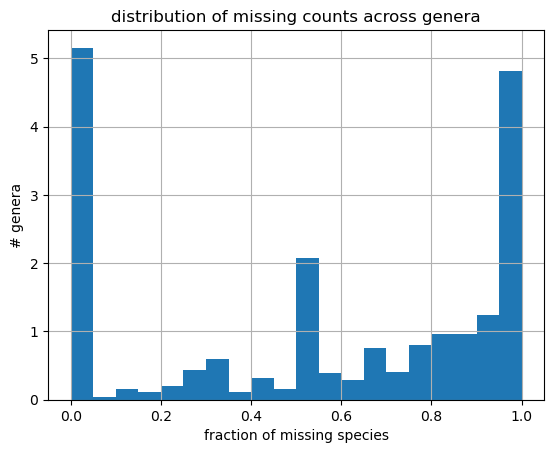

In [40]:
fig, ax = plt.subplots()
genus_stats_df.frac_missing.hist(ax=ax, density=True, bins=20)
ax.set_xlabel("fraction of missing species")
ax.set_ylabel("# genera")
ax.set_title("distribution of missing counts across genera")